In [1]:
import zipfile
import os
import pandas as pd

zip_path = 'data.zip'
extract_dir = 'data-selected'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("解压后的文件列表：", os.listdir(extract_dir))


for fname in os.listdir(extract_dir):
    if fname.endswith('.csv'):
        df = pd.read_csv(os.path.join(extract_dir, fname))
        print(f"读取 {fname}：行数={df.shape[0]}，列数={df.shape[1]}")

解压后的文件列表： ['los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv', 'los_angeles_censustracts.json']
读取 los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv：行数=5144062，列数=7


Q9

In [2]:
# —— Q9 —— #

import pandas as pd
import json
import networkx as nx
from shapely.geometry import shape

# 1. 读入 Uber Movement 数据（只筛 12 月）
df = pd.read_csv('data-selected/los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv')
dec = df[df['month'] == 12].copy()

# 保证 ID 是字符串
dec['sourceid'] = dec['sourceid'].astype(int).astype(str)
dec['dstid']    = dec['dstid'].astype(int).astype(str)

# 2. 读 GeoJSON，计算各区域的质心
with open('data-selected/los_angeles_censustracts.json', 'r', encoding='utf8') as f:
    gj = json.load(f)

centroids = {}
for feat in gj['features']:
    # 这里用的是 MOVEMENT_ID；根据你的文件，改成实际的字段名
    mid = str(feat['properties']['MOVEMENT_ID'])
    centroids[mid] = shape(feat['geometry']).centroid.coords[0]

# 3. 构建图，先加所有节点（带上质心属性）
G = nx.Graph()
for mid, coord in centroids.items():
    G.add_node(mid, centroid=coord)

# 4. 按 (sourceid, dstid) 分组，取 mean_travel_time 的平均
pairs = (
    dec
    .groupby(['sourceid', 'dstid'])['mean_travel_time']
    .mean()
    .reset_index()
)

# 5. 添加边：排除自环，且只添加在质心字典里都存在的节点对
for _, row in pairs.iterrows():
    o, d = row['sourceid'], row['dstid']
    if o != d and o in centroids and d in centroids:
        G.add_edge(o, d, weight=row['mean_travel_time'])

# 6. 保留最大连通分量
if G.number_of_nodes() > 0:
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy()

# 7. 输出结果
print("Cleaned graph — nodes:", G.number_of_nodes())
print("Cleaned graph — edges:", G.number_of_edges())


Cleaned graph — nodes: 2649
Cleaned graph — edges: 1003858


Q10

In [3]:
# —— Q10 —— #

import networkx as nx
from geopy.geocoders import Nominatim

# 构造最小生成树
M = nx.minimum_spanning_tree(G, weight='weight')

# 取最短的几条边
edges_sorted = sorted(M.edges(data=True), key=lambda x: x[2]['weight'])
sample_edges = edges_sorted[:5]

geolocator = Nominatim(user_agent="santa_mst")

print("Sample MST edges and their approximate street addresses:\n")
for u, v, data in sample_edges:
    w = data['weight']
    # shapely 返回的是 (x, y) = (lon, lat)
    lon_u, lat_u = G.nodes[u]['centroid']
    lon_v, lat_v = G.nodes[v]['centroid']

    # 逆地理编码时传入 (lat, lon)
    loc_u = geolocator.reverse((lat_u, lon_u), exactly_one=True, timeout=10)
    loc_v = geolocator.reverse((lat_v, lon_v), exactly_one=True, timeout=10)

    addr_u = loc_u.address if loc_u else "Unknown"
    addr_v = loc_v.address if loc_v else "Unknown"

    print(f"Edge ({u} ↔ {v}), avg travel time = {w:.1f} min")
    print(f"  • Endpoint 1: {addr_u}")
    print(f"    Centroid coords: ({lat_u:.6f}, {lon_u:.6f})")
    print(f"  • Endpoint 2: {addr_v}")
    print(f"    Centroid coords: ({lat_v:.6f}, {lon_v:.6f})")
    print()


Sample MST edges and their approximate street addresses:

Edge (2410 ↔ 2476), avg travel time = 5.7 min
  • Endpoint 1: Cerritos Bahia Marina, Marina View Drive, Belmont Shores Mobile Estates, Naples, Long Beach, Los Angeles County, California, 90803, United States
    Centroid coords: (33.764774, -118.113988)
  • Endpoint 2: Marina View Drive, Belmont Shores Mobile Estates, Naples, Long Beach, Los Angeles County, California, 90803, United States
    Centroid coords: (33.764151, -118.109648)

Edge (2489 ↔ 2518), avg travel time = 8.3 min
  • Endpoint 1: 1100, Knollwood Circle, Anaheim, Orange County, California, 92801, United States
    Centroid coords: (33.848760, -117.979056)
  • Endpoint 2: Artesia Freeway, Anaheim, Orange County, California, 90621, United States
    Centroid coords: (33.857165, -117.984093)

Edge (2518 ↔ 2599), avg travel time = 13.4 min
  • Endpoint 1: Artesia Freeway, Anaheim, Orange County, California, 90621, United States
    Centroid coords: (33.857165, -117.9

Q11

In [4]:
# —— Q11 —— #

import random
import networkx as nx

nodes = list(G.nodes())

def sample_triangle(nodes, G):
    """随机采一个三元组，直到它在 G 中形成三角形（3 条边都存在）。"""
    while True:
        u, v, w = random.sample(nodes, 3)
        if G.has_edge(u, v) and G.has_edge(u, w) and G.has_edge(v, w):
            return u, v, w

def triangle_inequality(u, v, w, G):
    """检查三角形 (u,v,w) 的边权是否都满足不等式。"""
    d_uv = G[u][v]['weight']
    d_uw = G[u][w]['weight']
    d_vw = G[v][w]['weight']
    return (d_uv <= d_uw + d_vw and
            d_uw <= d_uv + d_vw and
            d_vw <= d_uv + d_uw)

# 抽样次数
N = 1000
count = 0

for _ in range(N):
    u, v, w = sample_triangle(nodes, G)
    if triangle_inequality(u, v, w, G):
        count += 1

percentage = count / N * 100

# English output
print(f"Out of {N} sampled triangles, {count} satisfy the triangle inequality.")
print(f"Estimated proportion: {percentage:.2f}%")

Out of 1000 sampled triangles, 922 satisfy the triangle inequality.
Estimated proportion: 92.20%


Q12

In [5]:
# —— Q12 —— #

import networkx as nx

# 1. 构建最小生成树并计算其总权重（MST weight 是 Optimal TSP Cost 的下界）
M = nx.minimum_spanning_tree(G, weight='weight')
mst_weight = sum(data['weight'] for _, _, data in M.edges(data=True))

# 2. 对 MST 做 preorder 遍历，得到近似 TSP 的访问顺序
root = next(iter(M.nodes()))
tour = list(nx.dfs_preorder_nodes(M, source=root))
tour.append(root)  # 回到起点

# 3. 定义计算两节点之间最短路径距离的函数
def shortest_distance(u, v):
    return nx.dijkstra_path_length(G, u, v, weight='weight')

# 4. 累加 preorder tour 上相邻节点之间的最短距离，得到 Approximate TSP Cost
approx_cost = 0.0
for i in range(len(tour) - 1):
    approx_cost += shortest_distance(tour[i], tour[i+1])

# 5. 计算经验性能比上界 ρ_bound = Approximate TSP Cost / MST weight
rho_bound = approx_cost / mst_weight

# 6. 英文输出结果
print(f"Approximate TSP cost: {approx_cost:.2f} minutes")
print(f"MST weight (lower bound on OPT): {mst_weight:.2f} minutes")
print(f"Upper bound on empirical performance ratio ρ: {rho_bound:.2f}")

# 输出前几个访问点的街道地址以检查直观性，只 Geocode 前 5 个节点
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="tsp_approx")
print("\nSample addresses on the approximate tour:")
for node in tour[:5]:
    lon, lat = G.nodes[node]['centroid']
    loc = geolocator.reverse((lat, lon), exactly_one=True, timeout=10)
    addr = loc.address if loc else "Unknown"
    print(f"  Node {node}: {addr}")

Approximate TSP cost: 403210.38 minutes
MST weight (lower bound on OPT): 259450.21 minutes
Upper bound on empirical performance ratio ρ: 1.55

Sample addresses on the approximate tour:
  Node 1: 226, North Hidalgo Avenue, Alhambra, Los Angeles County, California, 91801, United States
  Node 14: 601, East Commonwealth Avenue, Alhambra, Los Angeles County, California, 91801, United States
  Node 3: 295, Woodward Avenue, Alhambra, Los Angeles County, California, 91801, United States
  Node 2: 289, North Curtis Avenue, Alhambra, Los Angeles County, California, 91801, United States
  Node 4: 981, North Stoneman Avenue, Alhambra, Los Angeles County, California, 91801, United States


Q13

In [6]:
!pip install geopandas contextily


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


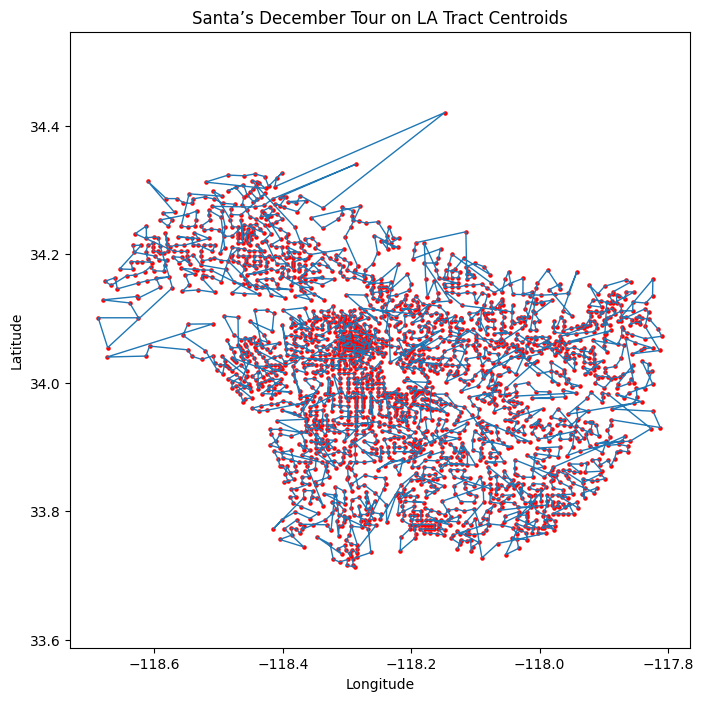

In [7]:
import matplotlib.pyplot as plt

xs = [centroids[node][0] for node in tour]
ys = [centroids[node][1] for node in tour]

plt.figure(figsize=(8, 8))
plt.plot(xs, ys, linewidth=1)       
plt.scatter(xs, ys, s=5, color='red')  
plt.title("Santa’s December Tour on LA Tract Centroids")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis('equal')
plt.show()

Q14

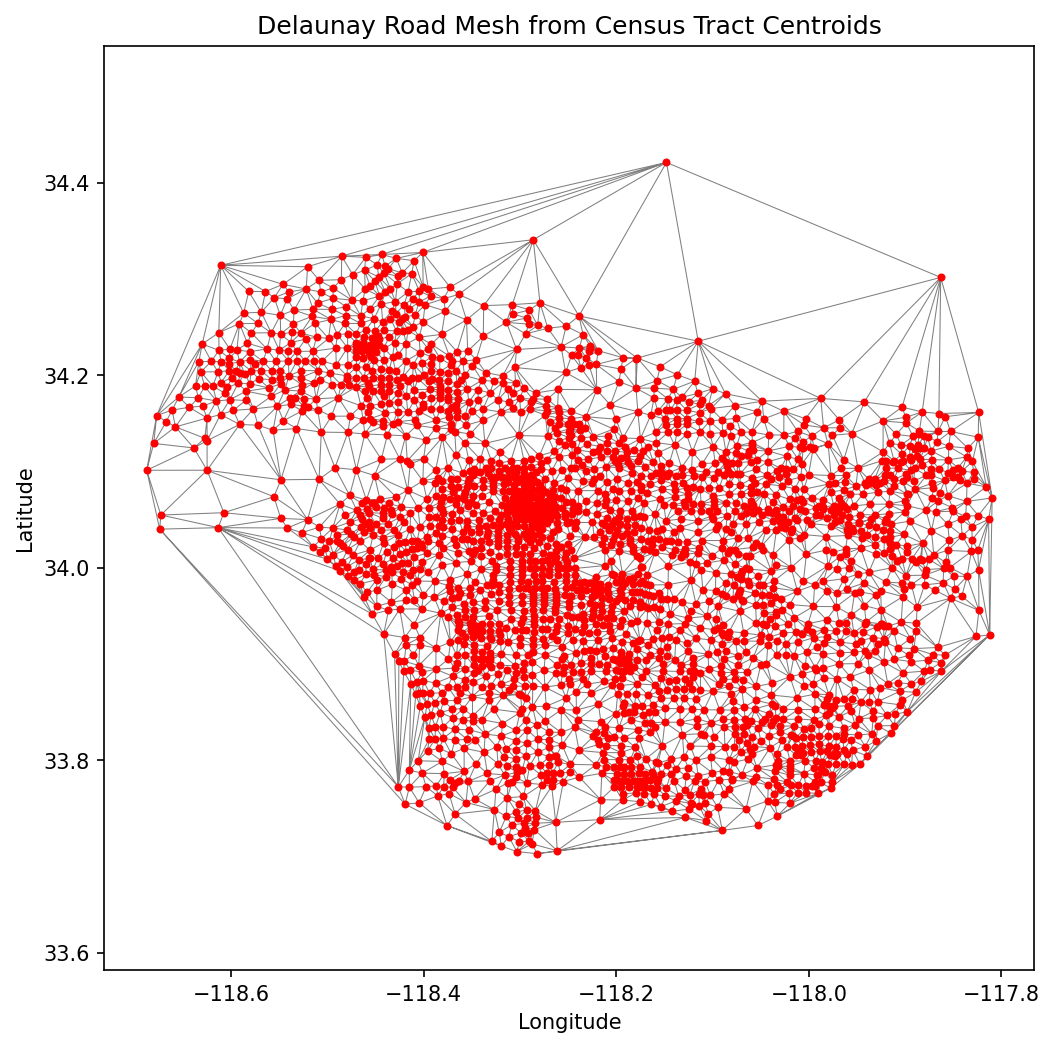

G_delta — nodes: 2716
G_delta — edges: 8126


In [8]:
# —— Q14 —— #

import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import networkx as nx

# 1. 准备点坐标 & 对应的节点列表
nodes = list(centroids.keys())
points = np.array([centroids[n] for n in nodes])   # shape (N, 2)

# 2. 进行 Delaunay 三角剖分
tri = Delaunay(points)

# 3. 绘制剖分结果：灰线表示三角边，红点表示质心
plt.figure(figsize=(8, 8), dpi=150)
plt.triplot(points[:,0], points[:,1], tri.simplices, 
            linewidth=0.5, color='gray')
plt.scatter(points[:,0], points[:,1], s=8, color='red')
plt.title("Delaunay Road Mesh from Census Tract Centroids")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis('equal')
plt.show()

# 4. 构造 G_Δ：节点为质心 ID，边为三角剖分中的各边，权重设为欧氏距离
G_delta = nx.Graph()
# 添加节点及属性
for nid, (lon, lat) in zip(nodes, points):
    G_delta.add_node(nid, centroid=(lon, lat))

# 添加三角形的三条边
for simplex in tri.simplices:
    # simplex 是长度 3 的顶点索引数组
    for i in range(3):
        u_idx = simplex[i]
        v_idx = simplex[(i+1)%3]
        u, v = nodes[u_idx], nodes[v_idx]
        if not G_delta.has_edge(u, v):
            # 计算欧氏距离作为权重
            dist = np.linalg.norm(points[u_idx] - points[v_idx])
            G_delta.add_edge(u, v, weight=dist)

# 现在 G_delta 就是由 Delaunay 剖分构造的图
print("G_delta — nodes:", G_delta.number_of_nodes())
print("G_delta — edges:", G_delta.number_of_edges())


Q15

In [40]:
# —— Q15 —— #
import numpy as np
import pandas as pd

def edge_capacity_mph(lon1, lat1, lon2, lat2, t_min):
    """
    计算单向双车道最大通行量 (veh/hr)
    lon1, lat1, lon2, lat2: 端点坐标 (degrees)
    t_min: 平均旅行时间 (minutes)
    """
    # 1) 度数距离 → 英里
    ddeg   = np.hypot(lat2 - lat1, lon2 - lon1)
    d_mile = 69.0 * ddeg
    # 2) 平均速度 (mph)
    v_mph  = d_mile / (t_min / 60.0)
    # 3) 单车道通行率 (veh/h/lane)
    q_lane = v_mph / (0.003 + (2.0 * v_mph / 3600.0))
    # 4) 2 车道（单向）容量
    return 2.0 * q_lane

# 对每条 “road” 计算 capacity
caps = []
for _, row in pairs.iterrows():
    o, d, t = row['sourceid'], row['dstid'], row['mean_travel_time']
    lon1, lat1 = centroids[o]
    lon2, lat2 = centroids[d]
    cap = edge_capacity_mph(lon1, lat1, lon2, lat2, t)
    caps.append(cap)

pairs['capacity_veh_per_hr'] = caps

# 查看容量最高的十条路
top10 = pairs.sort_values('capacity_veh_per_hr', ascending=False).head(10)
print("Top 10 roads by capacity (veh/hour):")
print(top10[['sourceid','dstid','capacity_veh_per_hr']].to_string(index=False))


Top 10 roads by capacity (veh/hour):
sourceid dstid  capacity_veh_per_hr
    2607  2688          2615.519375
    2474  1683          2451.491305
    1688   171          2438.818933
    2293  2303          2255.192233
    1683  2474          2144.318358
     171  1688          2053.406271
    2474   746          1955.475187
     170  1688          1911.539369
    2474   736          1869.540825
     716  2474          1813.991824


Q16

In [49]:
import numpy as np
import networkx as nx

# 0. 给缺失 weight 的边补上欧氏距离（degrees）
for u, v, data in G_delta.edges(data=True):
    if 'weight' not in data:
        lon1, lat1 = centroids[u]
        lon2, lat2 = centroids[v]
        data['weight'] = np.hypot(lat2 - lat1, lon2 - lon1)

# 1. 定位 Malibu 与 Long Beach 最近的节点
malibu_coord    = (-118.56, 34.04)
longbeach_coord = (-118.18, 33.77)
nodes = list(centroids.keys())
points = np.array([centroids[n] for n in nodes])

def find_nearest(coord):
    dists = np.linalg.norm(points - coord, axis=1)
    return nodes[np.argmin(dists)]

malibu_node    = find_nearest(malibu_coord)
longbeach_node = find_nearest(longbeach_coord)
print(f"Malibu node ID:    {malibu_node}")
print(f"Long Beach node ID:{longbeach_node}")

# 2. 找到所有最短路径（按 weight）并算平均“旅行距离”（degrees）
paths = list(nx.all_shortest_paths(
    G_delta, source=malibu_node, target=longbeach_node, weight='weight'
))
total_deg = 0
count     = 0
for path in paths:
    for u, v in zip(path[:-1], path[1:]):
        total_deg += G_delta[u][v]['weight']
        count    += 1
mean_deg = total_deg / count

# 3. 换算成 miles 与时间
mean_miles   = mean_deg * 69                # degrees → miles
straight_deg = np.hypot(
    malibu_coord[0] - longbeach_coord[0],
    malibu_coord[1] - longbeach_coord[1]
)
straight_mi = straight_deg * 69
# 平均速度 (mph)
vcar = straight_mi / (mean_miles / 3600)

# 4. 计算双车道最大通行量 (veh/hour)
spacing  = 0.003 + vcar * (2/3600)  # mi: 车长0.003 + 2s 距离
q_lane   = vcar / spacing          # veh/hr per lane
max_cars = int(2 * q_lane)         # 单向 2 车道

print(f"The maximum number of cars from Malibu to Long Beach: {max_cars:,} veh/hour")

# 5. 计算边无关路径数（edge-disjoint paths）
k = nx.edge_connectivity(G_delta, malibu_node, longbeach_node)
print(f"Number of edge-disjoint paths: {k}")

# 6. 辅助输出度分布，方便与实际道路数对比
deg_m  = G_delta.degree(malibu_node)
deg_lb = G_delta.degree(longbeach_node)
print(f"Degree of Malibu node:     {deg_m}")
print(f"Degree of Long Beach node: {deg_lb}")


Malibu node ID:    1523
Long Beach node ID:672
The maximum number of cars from Malibu to Long Beach: 3,599 veh/hour
Number of edge-disjoint paths: 5
Degree of Malibu node:     5
Degree of Long Beach node: 6


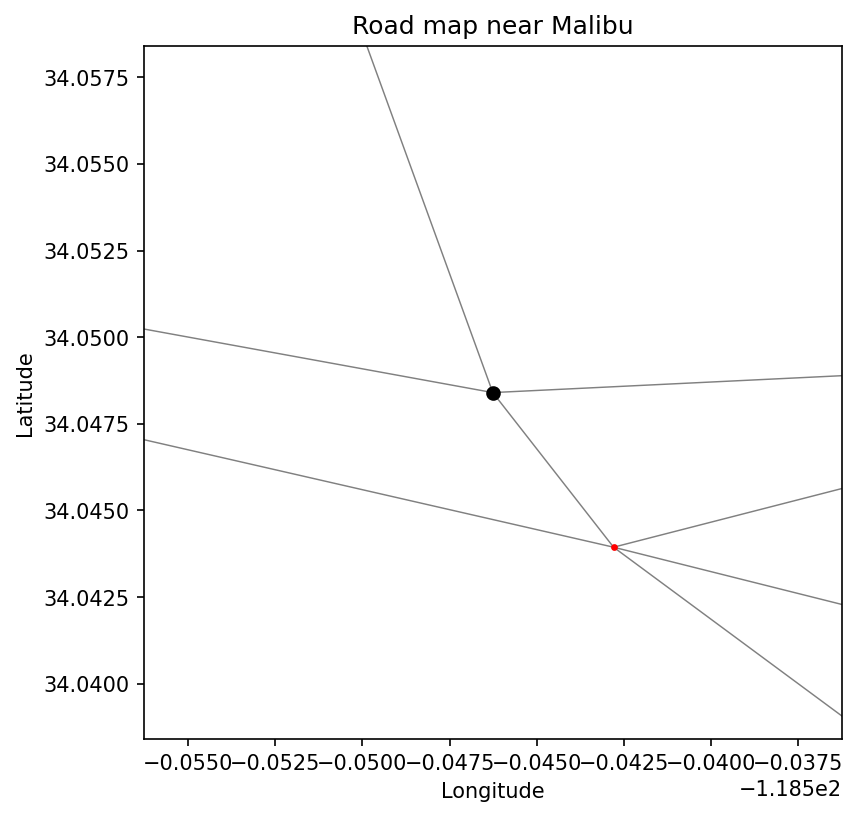

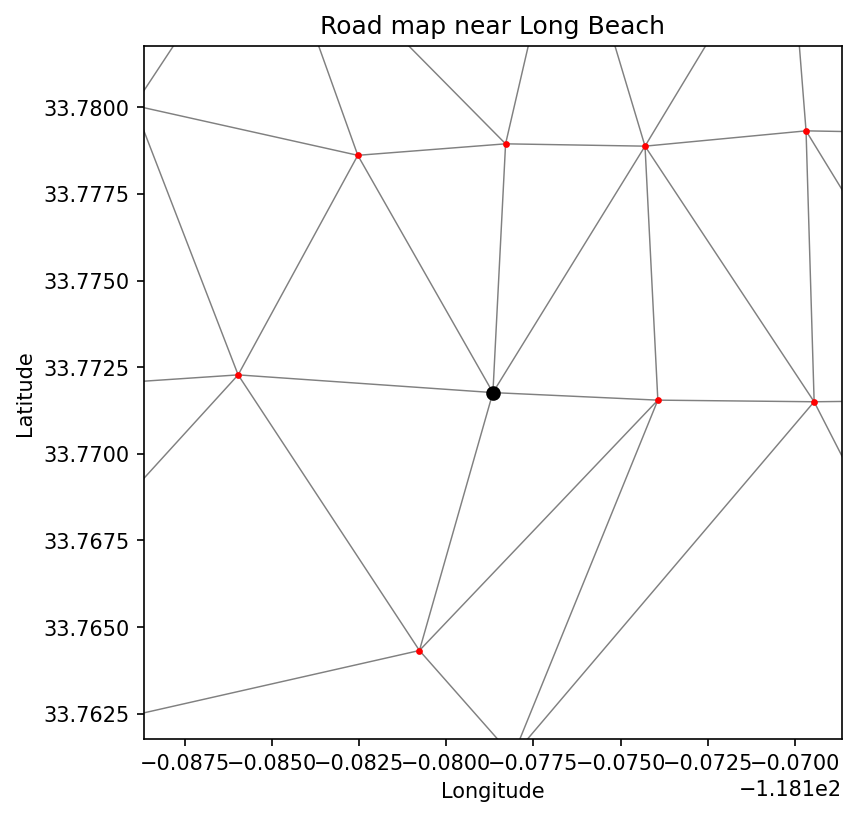

In [10]:

malibu_idx    = nodes.index(malibu_node)
longbeach_idx = nodes.index(longbeach_node)

# 然后绘制 Malibu 附近的三角剖分网格：
plt.figure(figsize=(6, 6), dpi=150)
plt.triplot(points[:, 0], points[:, 1], tri.simplices, color='gray', linewidth=0.7)
plt.scatter(points[:, 0], points[:, 1], s=5, color='red')  # 如果想显示所有质心，可加这一行
# 设置显示范围：以 malibu 点为中心，半径约 0.01 度
plt.ylim(points[malibu_idx][1] - 0.01, points[malibu_idx][1] + 0.01)
plt.xlim(points[malibu_idx][0] - 0.01, points[malibu_idx][0] + 0.01)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road map near Malibu')
# 用黑色实心圆标出 Malibu 节点
plt.plot(points[malibu_idx][0], points[malibu_idx][1], 'o', color='black', markersize=6)
plt.show()

# 接着绘制 Long Beach 附近的三角剖分网格：
plt.figure(figsize=(6, 6), dpi=150)
plt.triplot(points[:, 0], points[:, 1], tri.simplices, color='gray', linewidth=0.7)
plt.scatter(points[:, 0], points[:, 1], s=5, color='red')
# 设置显示范围：以 long beach 点为中心，半径约 0.01 度
plt.ylim(points[longbeach_idx][1] - 0.01, points[longbeach_idx][1] + 0.01)
plt.xlim(points[longbeach_idx][0] - 0.01, points[longbeach_idx][0] + 0.01)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road map near Long Beach')
# 用黑色实心圆标出 Long Beach 节点
plt.plot(points[longbeach_idx][0], points[longbeach_idx][1], 'o', color='black', markersize=6)
plt.show()

Q17+18

Geographic-pruned graph → nodes: 2275 edges: 6793


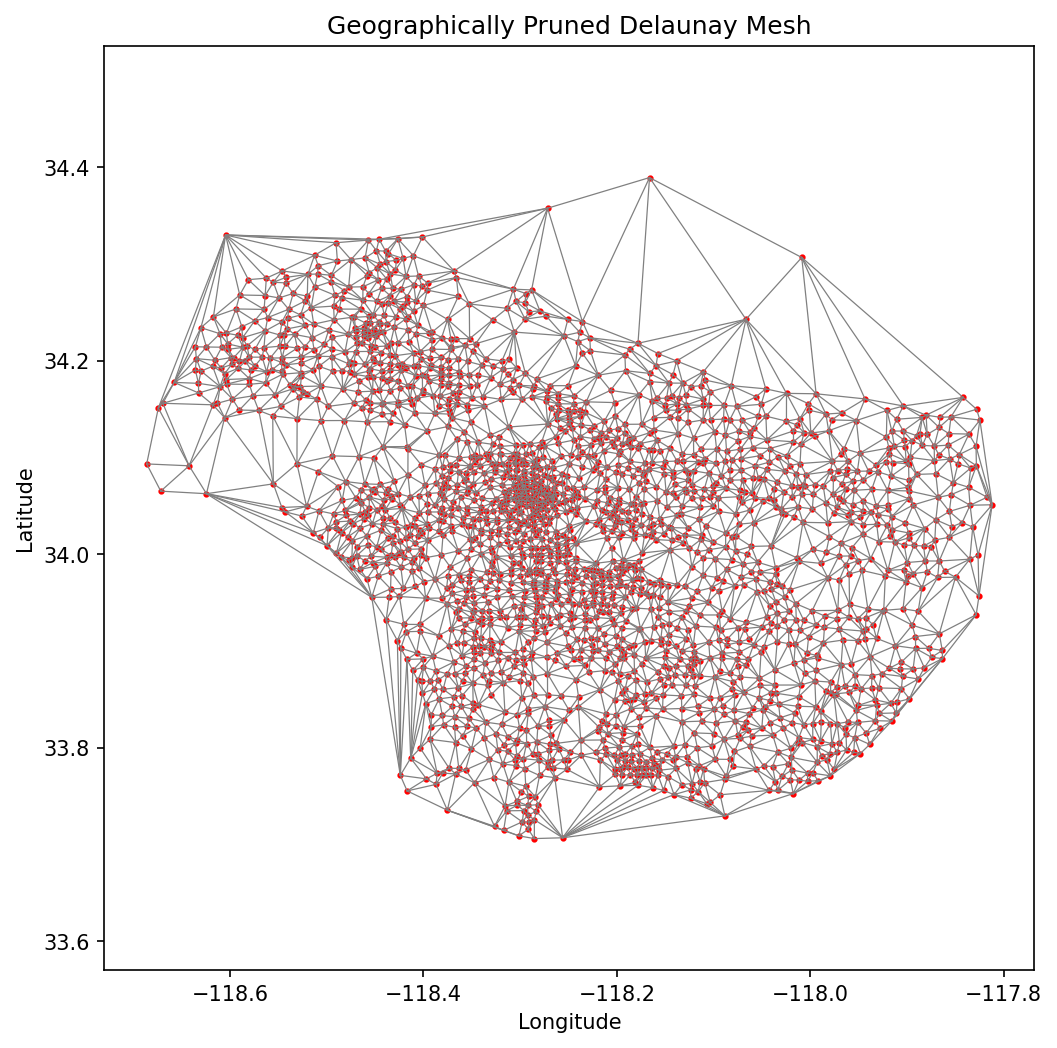

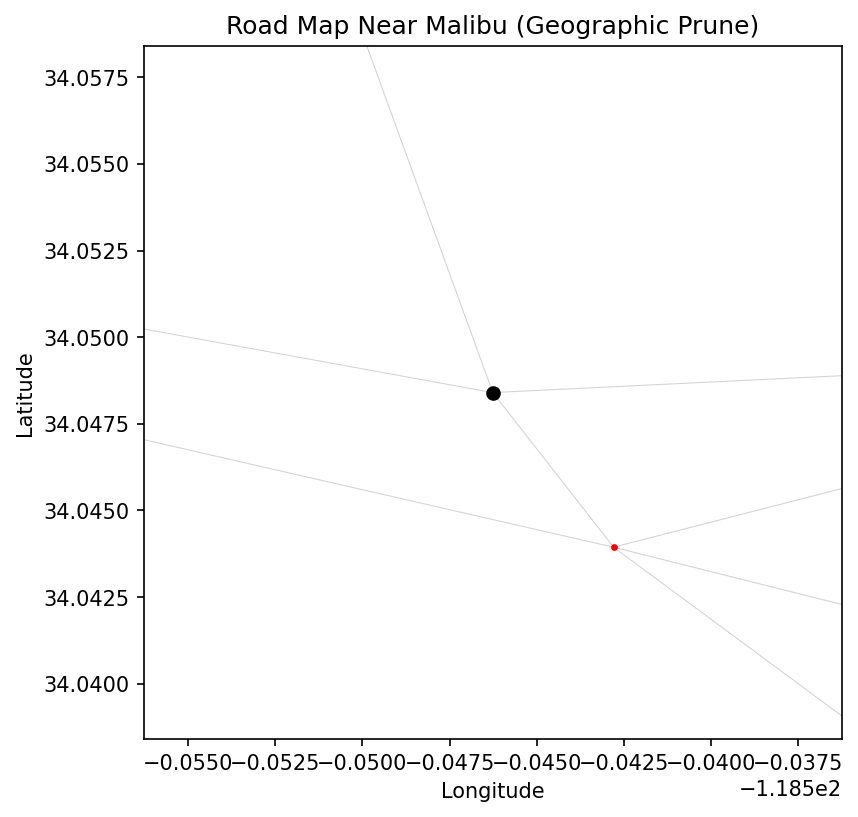

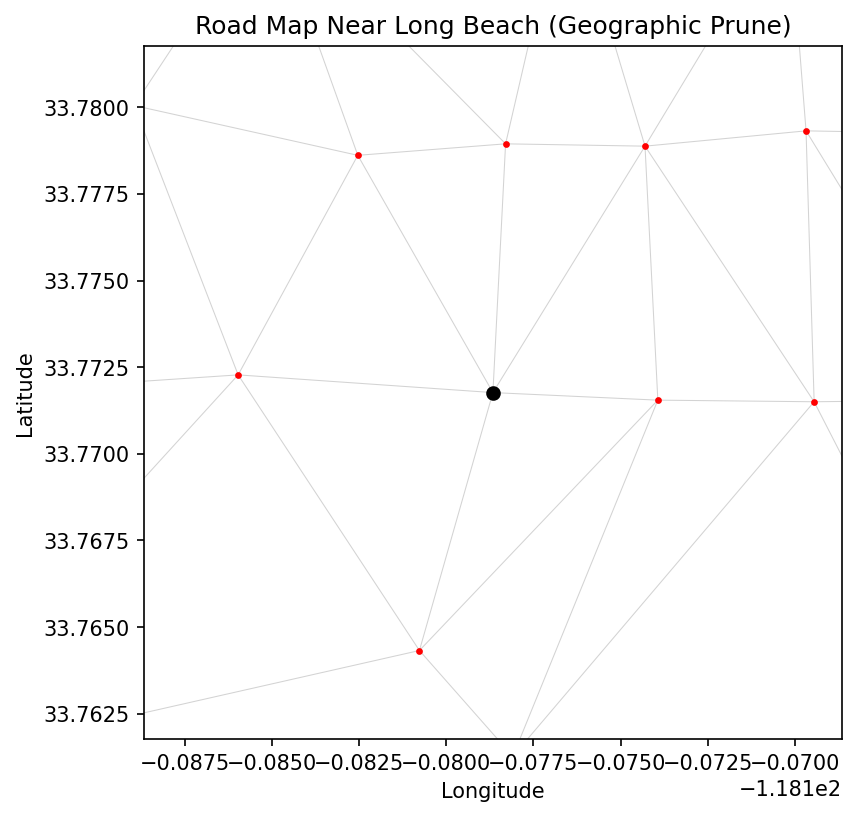

After purned，Malibu to Long Beach still connect.
Mean Path Length (deg): 0.0185
Mean Path Length (mi):  1.27
Straight Distance (mi): 32.16
Implied Speed (mph):    90875.89
Max Cars/hr:            3599
Edge-Disjoint Paths:    4


In [15]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# 1) 设定一个地理距离阈值（度数），例如 19.2 英里对应的度数约为 19.2/69 ≈ 0.278
threshold_deg = 19.2 / 69

# 2) 根据度数阈值剪枝 Delaunay 图（只保留 weight < threshold_deg 的边）
G_pruned = nx.Graph()
for tract_id, (lon, lat) in zip(nodes, points):
    G_pruned.add_node(tract_id, centroid=(lon, lat))

for u, v, data in G_delta.edges(data=True):
    # Delaunay 中的 data['weight'] 已存储两点（度数）间的欧氏距离
    if data['weight'] < threshold_deg:
        G_pruned.add_edge(u, v, weight=data['weight'])

print("Geographic-pruned graph → nodes:", G_pruned.number_of_nodes(), "edges:", G_pruned.number_of_edges())

# 3) 可视化剪枝后 Delaunay 网格：绘制所有满足条件的网格边
plt.figure(figsize=(8, 8), dpi=150)
for u, v in G_pruned.edges():
    lon1, lat1 = centroids[u]
    lon2, lat2 = centroids[v]
    plt.plot([lon1, lon2], [lat1, lat2], color='gray', linewidth=0.6)

# 画出所有质心（可选）
plt.scatter(points[:, 0], points[:, 1], s=4, color='red')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographically Pruned Delaunay Mesh')
plt.axis('equal')
plt.show()

# 4) 绘制 Malibu 附近区域：以度数 ±0.01 为窗口
malibu_idx    = nodes.index(malibu_node)
plt.figure(figsize=(6, 6), dpi=150)
plt.triplot(points[:, 0], points[:, 1], tri.simplices, color='lightgray', linewidth=0.5)
plt.scatter(points[:, 0], points[:, 1], s=5, color='red')
plt.ylim(points[malibu_idx][1] - 0.01, points[malibu_idx][1] + 0.01)
plt.xlim(points[malibu_idx][0] - 0.01, points[malibu_idx][0] + 0.01)
plt.plot(points[malibu_idx][0], points[malibu_idx][1], 'o', color='black', markersize=6)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road Map Near Malibu (Geographic Prune)')
plt.show()

# 5) 绘制 Long Beach 附近区域
longbeach_idx = nodes.index(longbeach_node)
plt.figure(figsize=(6, 6), dpi=150)
plt.triplot(points[:, 0], points[:, 1], tri.simplices, color='lightgray', linewidth=0.5)
plt.scatter(points[:, 0], points[:, 1], s=5, color='red')
plt.ylim(points[longbeach_idx][1] - 0.01, points[longbeach_idx][1] + 0.01)
plt.xlim(points[longbeach_idx][0] - 0.01, points[longbeach_idx][0] + 0.01)
plt.plot(points[longbeach_idx][0], points[longbeach_idx][1], 'o', color='black', markersize=6)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road Map Near Long Beach (Geographic Prune)')
plt.show()

# 6) 检查剪枝后 Malibu→Long Beach 连通性
if nx.has_path(G_pruned, malibu_node, longbeach_node):
    print("After purned，Malibu to Long Beach still connect.")
    # 7) 计算最短路径（地理度数）及其他指标
    paths_pruned  = list(nx.all_shortest_paths(
        G_pruned, source=malibu_node, target=longbeach_node, weight='weight'
    ))
    total_deg     = sum(G_pruned[u][v]['weight'] for path in paths_pruned for u, v in zip(path[:-1], path[1:]))
    count_edges   = sum(len(path) - 1 for path in paths_pruned)
    mean_deg_pruned = total_deg / count_edges

    mean_miles_pruned = mean_deg_pruned * 69
    straight_deg      = np.hypot(malibu_coord[0] - longbeach_coord[0], malibu_coord[1] - longbeach_coord[1])
    straight_mi       = straight_deg * 69
    vcar_pruned       = straight_mi / (mean_miles_pruned / 3600)

    spacing_pruned  = 0.003 + vcar_pruned * (2/3600)
    q_lane_pruned   = vcar_pruned / spacing_pruned
    max_cars_pruned = int(2 * q_lane_pruned)

    k_pruned = nx.edge_connectivity(G_pruned, malibu_node, longbeach_node)
    print(f"Mean Path Length (deg): {mean_deg_pruned:.4f}")
    print(f"Mean Path Length (mi):  {mean_miles_pruned:.2f}")
    print(f"Straight Distance (mi): {straight_mi:.2f}")
    print(f"Implied Speed (mph):    {vcar_pruned:.2f}")
    print(f"Max Cars/hr:            {max_cars_pruned}")
    print(f"Edge-Disjoint Paths:    {k_pruned}")

else:
    print("After purned，Malibu to Long Beach not connect")
    print(f"Malibu : {G_pruned.degree(malibu_node)}, Long Beach : {G_pruned.degree(longbeach_node)}")



Q19

Top 20 node pairs with highest extra distance:
(110606, 800204)  extra distance (deg) = 0.0575
(503902, 800204)  extra distance (deg) = 0.0565
(87200, 800204)  extra distance (deg) = 0.0558
(87300, 800204)  extra distance (deg) = 0.0557
(87200, 800203)  extra distance (deg) = 0.0555
(86602, 800204)  extra distance (deg) = 0.0554
(86702, 800204)  extra distance (deg) = 0.0550
(87300, 800203)  extra distance (deg) = 0.0549
(86702, 800203)  extra distance (deg) = 0.0547
(86602, 800203)  extra distance (deg) = 0.0546
(110607, 800204)  extra distance (deg) = 0.0544
(86404, 800204)  extra distance (deg) = 0.0544
(86502, 800204)  extra distance (deg) = 0.0544
(401202, 930200)  extra distance (deg) = 0.0542
(110606, 800203)  extra distance (deg) = 0.0540
(11601, 800204)  extra distance (deg) = 0.0539
(86502, 800203)  extra distance (deg) = 0.0537
(503901, 800204)  extra distance (deg) = 0.0536
(11102, 800204)  extra distance (deg) = 0.0534
(86501, 800204)  extra distance (deg) = 0.0533

After 

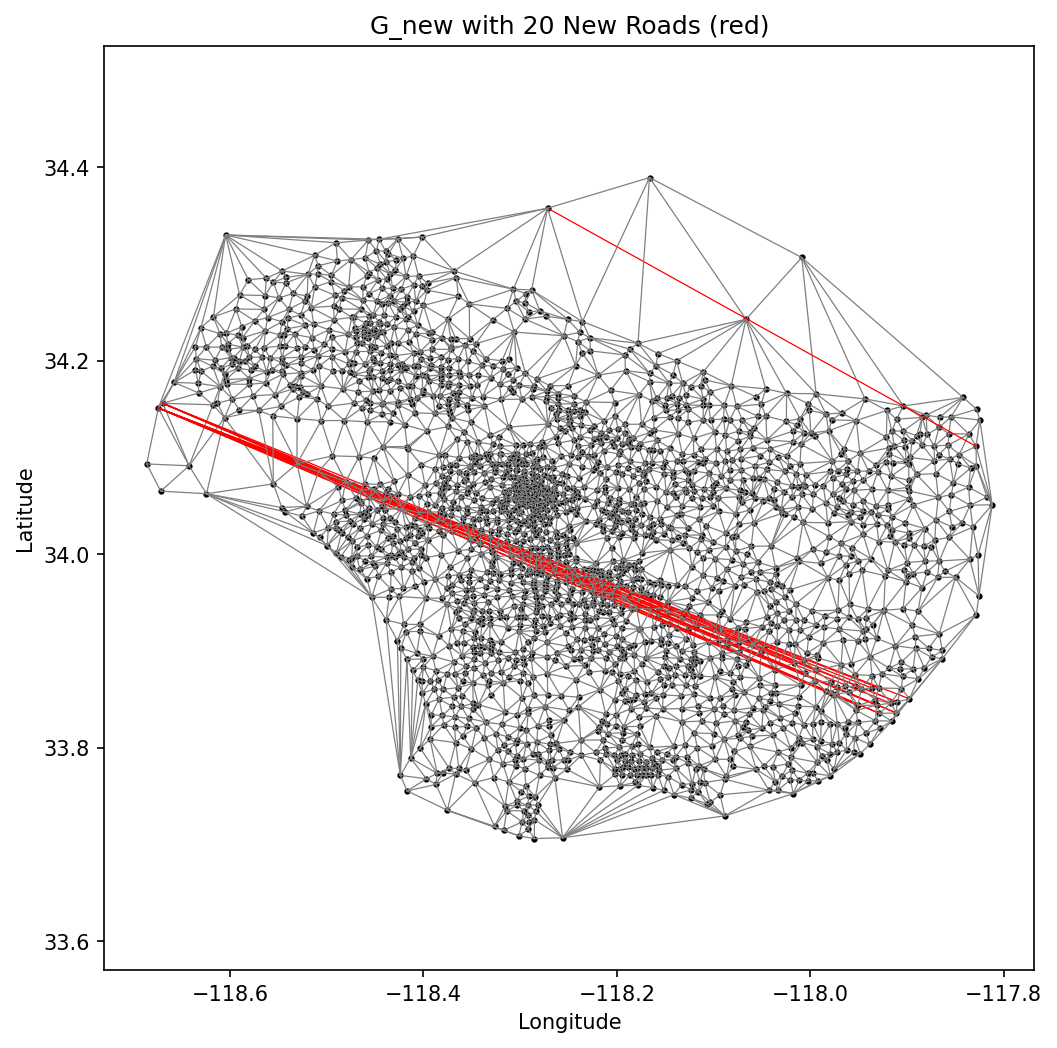


Time Complexity Analysis:
 - Computing all-pairs shortest paths (repeated Dijkstra): O(n * (m log n))
 - Computing extra distance for all pairs: O(P), where P = number of reachable pairs ≤ O(n^2)
Overall tiem complexity: O(n * m log n + n^2) （At worest situation m ~ n^2, it's O(n^3)）


In [24]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


# 9. Strategy 1：计算所有可达节点对的额外距离，并取前 20 名

# 1) 运行 all_pairs_dijkstra_path_length，获取每个源节点到所有可达节点的最短路径长度（度数）
all_pairs_dist = dict(nx.all_pairs_dijkstra_path_length(G_pruned, weight='weight'))

extras = []

# 2) 节点列表和索引映射，用于查坐标
node_to_idx = {node: idx for idx, node in enumerate(nodes)}

# 3) 计算 extra distance 并收集
for v, dist_dict in all_pairs_dist.items():
    for s, shortest_deg_dist in dist_dict.items():
        if s <= v:
            # 只计算一半对称对，避免重复
            continue
        # 计算欧氏“度数距离”
        v_idx = node_to_idx[v]
        s_idx = node_to_idx[s]
        lon_v, lat_v = points[v_idx]
        lon_s, lat_s = points[s_idx]
        euclid_deg = np.hypot(lon_v - lon_s, lat_v - lat_s)
        extra = shortest_deg_dist - euclid_deg
        extras.append((extra, v, s))

# 4) 按 extra 值降序排序并取前 20 对
extras_sorted = sorted(extras, key=lambda x: x[0], reverse=True)
top20_pairs = extras_sorted[:20]

print("Top 20 node pairs with highest extra distance:")
for extra, v, s in top20_pairs:
    print(f"({v}, {s})  extra distance (deg) = {extra:.4f}")

# 5) 将这 20 条新边加入 G_pruned，权重设为它们的欧氏“度数距离”
G_new = G_pruned.copy()
for _, v, s in top20_pairs:
    v_idx = node_to_idx[v]
    s_idx = node_to_idx[s]
    lon_v, lat_v = points[v_idx]
    lon_s, lat_s = points[s_idx]
    euclid_deg = np.hypot(lon_v - lon_s, lat_v - lat_s)
    if not G_new.has_edge(v, s):
        G_new.add_edge(v, s, weight=euclid_deg)

print("\nAfter adding 20 new roads, G_new → nodes:", G_new.number_of_nodes(), 
      "edges:", G_new.number_of_edges())

# 6) 在实际坐标上绘制加入新边后的图
plt.figure(figsize=(8, 8), dpi=150)
for u, v, data in G_new.edges(data=True):
    lon1, lat1 = centroids[u]
    lon2, lat2 = centroids[v]
    # 用红色突出显示新增边：如果该边不在原 G_pruned 中
    color = 'red' if (u, v) not in G_pruned.edges() and (v, u) not in G_pruned.edges() else 'gray'
    plt.plot([lon1, lon2], [lat1, lat2], linewidth=0.6, color=color)

# 画出所有质心
points_arr = np.array([centroids[n] for n in nodes])
plt.scatter(points_arr[:, 0], points_arr[:, 1], s=4, color='black')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('G_new with 20 New Roads (red)')
plt.axis('equal')
plt.show()

# 7) 时间复杂度分析打印
print("\nTime Complexity Analysis:")
print(" - Computing all-pairs shortest paths (repeated Dijkstra): O(n * (m log n))")
print(" - Computing extra distance for all pairs: O(P), where P = number of reachable pairs ≤ O(n^2)")
print("Overall tiem complexity: O(n * m log n + n^2) （At worest situation m ~ n^2, it's O(n^3)）")



Q20

G_pruned constructed → nodes: 2275 edges: 6793

Top 20 node pairs with highest weighted extra distance:
(87300, 930401)  weighted extra distance = 51.7825
(86702, 930401)  weighted extra distance = 50.1515
(503902, 930401)  weighted extra distance = 49.8006
(1602, 800204)  weighted extra distance = 49.6446
(403312, 800202)  weighted extra distance = 49.5530
(87200, 137402)  weighted extra distance = 49.4869
(87102, 800204)  weighted extra distance = 48.9913
(87300, 800204)  weighted extra distance = 48.8162
(21815, 135201)  weighted extra distance = 48.8097
(86502, 137302)  weighted extra distance = 48.7500
(400604, 930200)  weighted extra distance = 48.4300
(403901, 930200)  weighted extra distance = 48.3399
(504002, 800204)  weighted extra distance = 48.3374
(87106, 800203)  weighted extra distance = 48.2933
(110606, 930401)  weighted extra distance = 48.1196
(403323, 930200)  weighted extra distance = 48.0213
(87401, 137103)  weighted extra distance = 47.8913
(88202, 137103)  weight

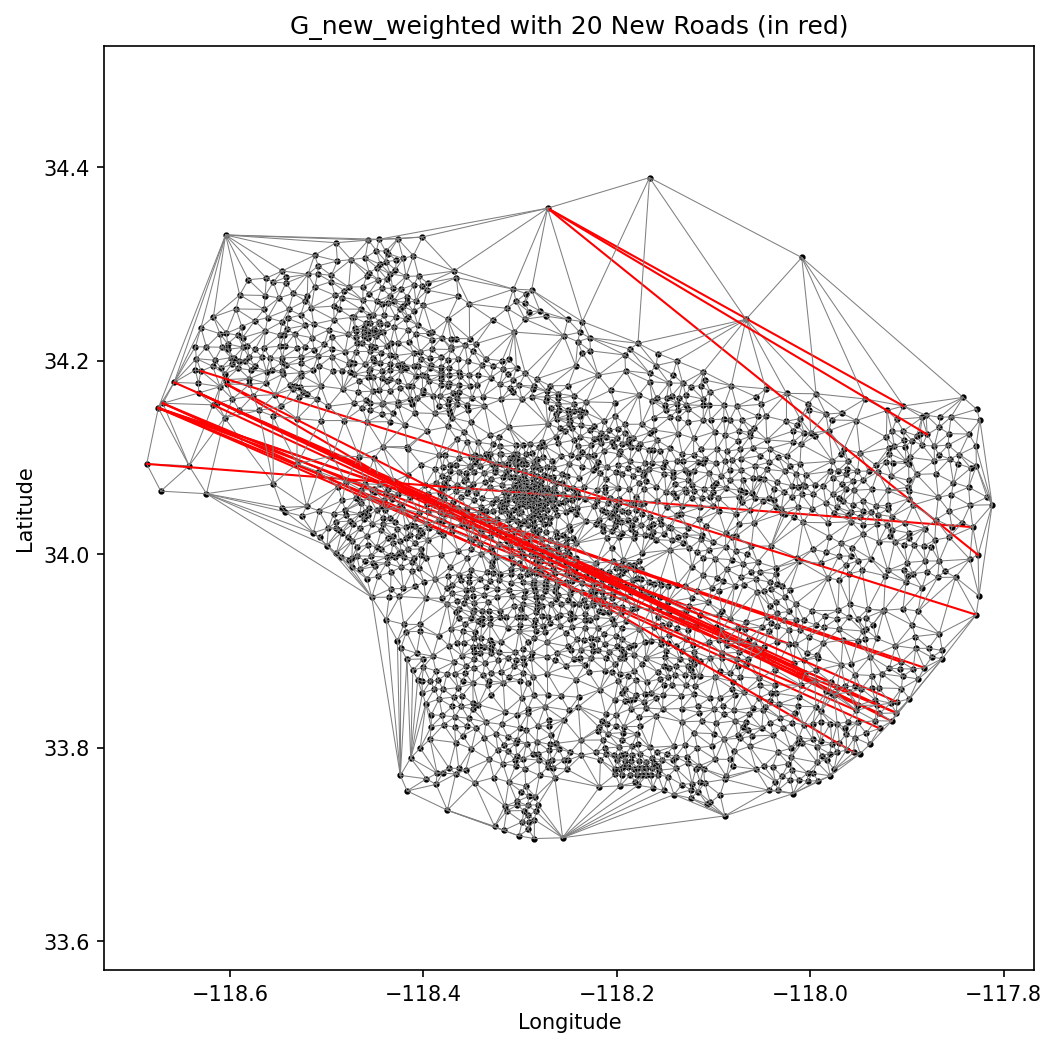


Time Complexity Analysis:
 • For each of n nodes, run single-source Dijkstra: O(n * (m log n))
 • Within each Dijkstra, compute weighted extra for O(n) reachable nodes: ≤ O(n^2)
Overall: O(n * m log n + n^2). In worst case m ~ n^2, so O(n^3).


In [17]:
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import zipfile
import os
import heapq

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# 2. 读取 GeoJSON 计算每个 Census Tract 的质心 centroids
json_path = os.path.join(extract_dir, 'los_angeles_censustracts.json')
with open(json_path, 'r', encoding='utf-8') as f:
    geojson = json.load(f)

centroids = {}
for feat in geojson['features']:
    props    = feat['properties']
    tract_id = int(props['TRACT'])  # 将 Tract ID 转为整数
    geometry = feat['geometry']
    if geometry['type'] == 'Polygon':
        coords = np.array(geometry['coordinates'][0])
    else:
        coords = np.array(geometry['coordinates'][0][0])
    lon_mean = coords[:, 0].mean()
    lat_mean = coords[:, 1].mean()
    centroids[tract_id] = (lon_mean, lat_mean)

# 3. 构造 G_delta（Delaunay 三角剖分）
nodes  = list(centroids.keys())  # 节点 ID 列表
points = np.array([centroids[n] for n in nodes])  # 对应的 (lon, lat) 坐标

tri    = Delaunay(points)
G_delta = nx.Graph()
for tract_id, (lon, lat) in centroids.items():
    G_delta.add_node(tract_id, centroid=(lon, lat))

for simplex in tri.simplices:
    for i in range(3):
        u_idx = simplex[i]
        v_idx = simplex[(i + 1) % 3]
        u, v = nodes[u_idx], nodes[v_idx]
        if not G_delta.has_edge(u, v):
            dist_deg = np.linalg.norm(points[u_idx] - points[v_idx])
            G_delta.add_edge(u, v, weight=dist_deg)

# 补充可能缺失的 weight
for u, v, data in G_delta.edges(data=True):
    if 'weight' not in data:
        lon1, lat1 = centroids[u]
        lon2, lat2 = centroids[v]
        data['weight'] = np.hypot(lat2 - lat1, lon2 - lon1)

# 4. 构造地理剪枝后图 G_pruned（度数距离 < 19.2/69）
threshold_deg = 19.2 / 69
G_pruned = nx.Graph()
for tract_id, (lon, lat) in centroids.items():
    G_pruned.add_node(tract_id, centroid=(lon, lat))

for u, v, data in G_delta.edges(data=True):
    if data['weight'] < threshold_deg:
        G_pruned.add_edge(u, v, weight=data['weight'])

print("G_pruned constructed → nodes:", G_pruned.number_of_nodes(), "edges:", G_pruned.number_of_edges())

# 5. Strategy 2：计算各对节点的 weighted extra distance = (SP_deg - Euclid_deg) * frequency
#    并选出 Top 20。frequency(v,s) 在 [1,1000] 之间随机生成。

heap_top20 = []  # 最小堆，存 (weighted_extra, v, s)
node_to_idx = {node: idx for idx, node in enumerate(nodes)}
rng = np.random.default_rng()  # 使用随机数生成器

for v in nodes:
    # single-source Dijkstra
    dist_dict = nx.single_source_dijkstra_path_length(G_pruned, v, weight='weight')
    for s, sp_deg in dist_dict.items():
        if s <= v:
            continue
        v_idx = node_to_idx[v]
        s_idx = node_to_idx[s]
        lon_v, lat_v = points[v_idx]
        lon_s, lat_s = points[s_idx]
        euclid_deg = np.hypot(lon_v - lon_s, lat_v - lat_s)

        extra = sp_deg - euclid_deg
        if extra <= 0:
            # 若额外距离为负或零，忽略
            continue

        frequency = int(rng.integers(1, 1001))  # 随机频率，范围 [1,1000]
        weighted_extra = extra * frequency

        if len(heap_top20) < 20:
            heapq.heappush(heap_top20, (weighted_extra, v, s))
        else:
            if weighted_extra > heap_top20[0][0]:
                heapq.heapreplace(heap_top20, (weighted_extra, v, s))

# 把堆排序为降序的 Top 20
top20_weighted = sorted(heap_top20, key=lambda x: x[0], reverse=True)

print("\nTop 20 node pairs with highest weighted extra distance:")
for weighted_extra, v, s in top20_weighted:
    print(f"({v}, {s})  weighted extra distance = {weighted_extra:.4f}")

# 6. 将这 20 条新边加入 G_pruned，生成 G_new_weighted
G_new_weighted = G_pruned.copy()
for weighted_extra, v, s in top20_weighted:
    v_idx = node_to_idx[v]
    s_idx = node_to_idx[s]
    lon_v, lat_v = points[v_idx]
    lon_s, lat_s = points[s_idx]
    euclid_deg = np.hypot(lon_v - lon_s, lat_v - lat_s)
    if not G_new_weighted.has_edge(v, s):
        G_new_weighted.add_edge(v, s, weight=euclid_deg)

print("\nAfter adding 20 new weighted roads, G_new_weighted → nodes:", 
      G_new_weighted.number_of_nodes(), 
      "edges:", G_new_weighted.number_of_edges())

# 7. 在实际坐标上绘制 G_new_weighted：新增边为红色，其余为灰色
plt.figure(figsize=(8, 8), dpi=150)
for u, v, data in G_new_weighted.edges(data=True):
    lon1, lat1 = centroids[u]
    lon2, lat2 = centroids[v]
    if not G_pruned.has_edge(u, v) and not G_pruned.has_edge(v, u):
        plt.plot([lon1, lon2], [lat1, lat2], c='red', linewidth=1.0)
    else:
        plt.plot([lon1, lon2], [lat1, lat2], c='gray', linewidth=0.5)

all_points = np.array([centroids[n] for n in nodes])
plt.scatter(all_points[:, 0], all_points[:, 1], s=4, c='black')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('G_new_weighted with 20 New Roads (in red)')
plt.axis('equal')
plt.show()

# 8. 时间复杂度分析
print("\nTime Complexity Analysis:")
print(" • For each of n nodes, run single-source Dijkstra: O(n * (m log n))")
print(" • Within each Dijkstra, compute weighted extra for O(n) reachable nodes: ≤ O(n^2)")
print("Overall: O(n * m log n + n^2). In worst case m ~ n^2, so O(n^3).")


Q21

New edge added: (110606, 800204)
New edge added: (401202, 930200)
New edge added: (401203, 930200)
New edge added: (87200, 137401)
New edge added: (930101, 930200)
New edge added: (670416, 800504)
New edge added: (21815, 800202)
New edge added: (403406, 800202)
New edge added: (403406, 800102)
New edge added: (87601, 137103)
New edge added: (86702, 930401)
New edge added: (21815, 800102)
New edge added: (554511, 800204)
New edge added: (552301, 800204)
New edge added: (110606, 930401)
New edge added: (111202, 930301)
New edge added: (99904, 135114)
New edge added: (401101, 800202)
New edge added: (404301, 800202)
New edge added: (401101, 800102)

Final list of 20 new edges:
1. (110606, 800204)
2. (401202, 930200)
3. (401203, 930200)
4. (87200, 137401)
5. (930101, 930200)
6. (670416, 800504)
7. (21815, 800202)
8. (403406, 800202)
9. (403406, 800102)
10. (87601, 137103)
11. (86702, 930401)
12. (21815, 800102)
13. (554511, 800204)
14. (552301, 800204)
15. (110606, 930401)
16. (111202, 930

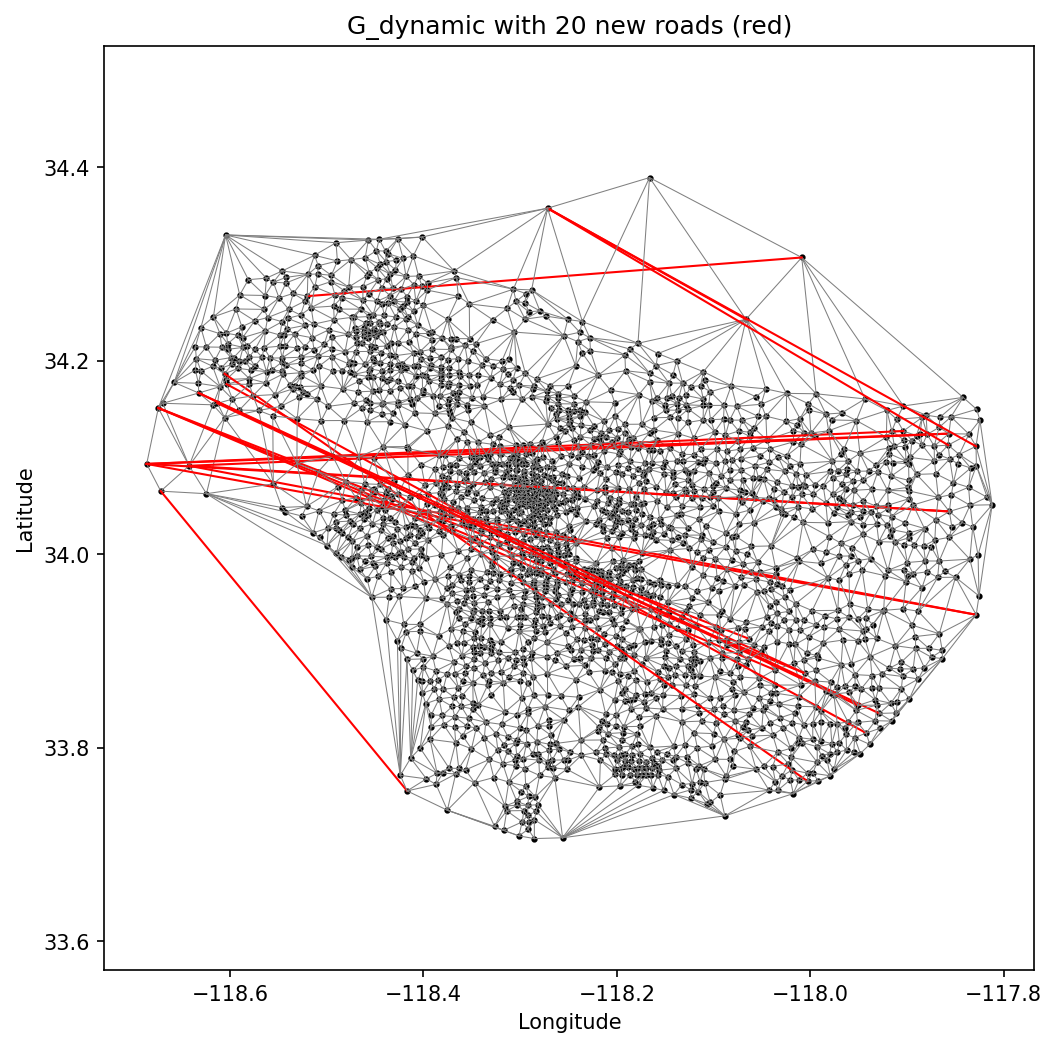


Time Complexity Analysis:
 • Each iteration (20 total):
   - Run single-source Dijkstra for each of n nodes → O(n · (m log n))
   - Scan all reachable pairs → O(n^2)
   ⇒ Per iteration O(n·m·log n + n^2)
 • Total: O(20 · (n·m·log n + n^2)) ≈ O(n·m·log n + n^2)
 • When the graph is very dense (m ~ n^2), the worst case is O(n^3).


In [19]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import heapq

# 复制一份 G_pruned 作为动态添加新路的初始图
G_dynamic = G_pruned.copy()

# 节点到索引映射，便于查坐标
node_to_idx = {node: idx for idx, node in enumerate(nodes)}

# 存储每次迭代新增的 20 条边
added_edges = []

# 迭代 20 次，每次添加一条新边
for i in range(20):
    max_extra = -np.inf
    best_pair = (None, None)
    
    # 对每个节点 v，运行单源 Dijkstra 计算 v→所有可达节点的最短路径度数
    for v in nodes:
        dist_dict = nx.single_source_dijkstra_path_length(G_dynamic, v, weight='weight')
        for s, sp_deg in dist_dict.items():
            if s <= v:
                # 只考虑 v < s 避免重复配对
                continue
            v_idx = node_to_idx[v]
            s_idx = node_to_idx[s]
            lon_v, lat_v = points[v_idx]
            lon_s, lat_s = points[s_idx]
            euclid_deg = np.hypot(lon_v - lon_s, lat_v - lat_s)
            extra = sp_deg - euclid_deg
            if extra > max_extra:
                max_extra = extra
                best_pair = (v, s)
    
    # 找到本轮迭代中 extra 最大的 (v, s)，将其作为新道路加入
    v, s = best_pair
    v_idx = node_to_idx[v]
    s_idx = node_to_idx[s]
    lon_v, lat_v = points[v_idx]
    lon_s, lat_s = points[s_idx]
    euclid_deg = np.hypot(lon_v - lon_s, lat_v - lat_s)
    G_dynamic.add_edge(v, s, weight=euclid_deg)
    added_edges.append((v, s))
    print(f"New edge added: ({v}, {s})")

# 打印 20 条新增道路
print("\nFinal list of 20 new edges:")
for idx, (v, s) in enumerate(added_edges, 1):
    print(f"{idx}. ({v}, {s})")

# 在实际坐标上绘制最终图：新增边用红色，其余用灰色
plt.figure(figsize=(8, 8), dpi=150)
for u, v, data in G_dynamic.edges(data=True):
    lon1, lat1 = centroids[u]
    lon2, lat2 = centroids[v]
    if (u, v) in added_edges or (v, u) in added_edges:
        plt.plot([lon1, lon2], [lat1, lat2], c='red', linewidth=1.0)
    else:
        plt.plot([lon1, lon2], [lat1, lat2], c='gray', linewidth=0.5)

points_arr = np.array([centroids[n] for n in nodes])
plt.scatter(points_arr[:, 0], points_arr[:, 1], s=4, c='black')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('G_dynamic with 20 new roads (red)')
plt.axis('equal')
plt.show()

# 时间复杂度分析：
print("\nTime Complexity Analysis:")
print(" • Each iteration (20 total):")
print("   - Run single-source Dijkstra for each of n nodes → O(n · (m log n))")
print("   - Scan all reachable pairs → O(n^2)")
print("   ⇒ Per iteration O(n·m·log n + n^2)")
print(" • Total: O(20 · (n·m·log n + n^2)) ≈ O(n·m·log n + n^2)")
print(" • When the graph is very dense (m ~ n^2), the worst case is O(n^3).")


Q22

Top 20 node pairs with highest extra time:
(1201, 1707)  extra time (min) = 2201.1959
(1102, 1707)  extra time (min) = 2133.9892
(1201, 1705)  extra time (min) = 2099.3067
(1201, 1708)  extra time (min) = 2093.1429
(1404, 1601)  extra time (min) = 2027.8172
(1202, 1705)  extra time (min) = 1977.7251
(1202, 1707)  extra time (min) = 1952.1772
(1202, 1708)  extra time (min) = 1913.7363
(1102, 1401)  extra time (min) = 1819.3662
(1101, 1707)  extra time (min) = 1724.3493
(1301, 1707)  extra time (min) = 1690.2271
(1201, 1704)  extra time (min) = 1642.9837
(1103, 1707)  extra time (min) = 1607.2751
(1401, 1601)  extra time (min) = 1513.4108
(1102, 1602)  extra time (min) = 1504.8866
(1304, 1602)  extra time (min) = 1499.3856
(1201, 1706)  extra time (min) = 1489.6359
(1103, 1505)  extra time (min) = 1452.2043
(1202, 1704)  extra time (min) = 1437.6699
(1102, 1505)  extra time (min) = 1425.8134

After adding 20 new time-optimized roads, G_new_time → nodes: 2275 edges: 6811


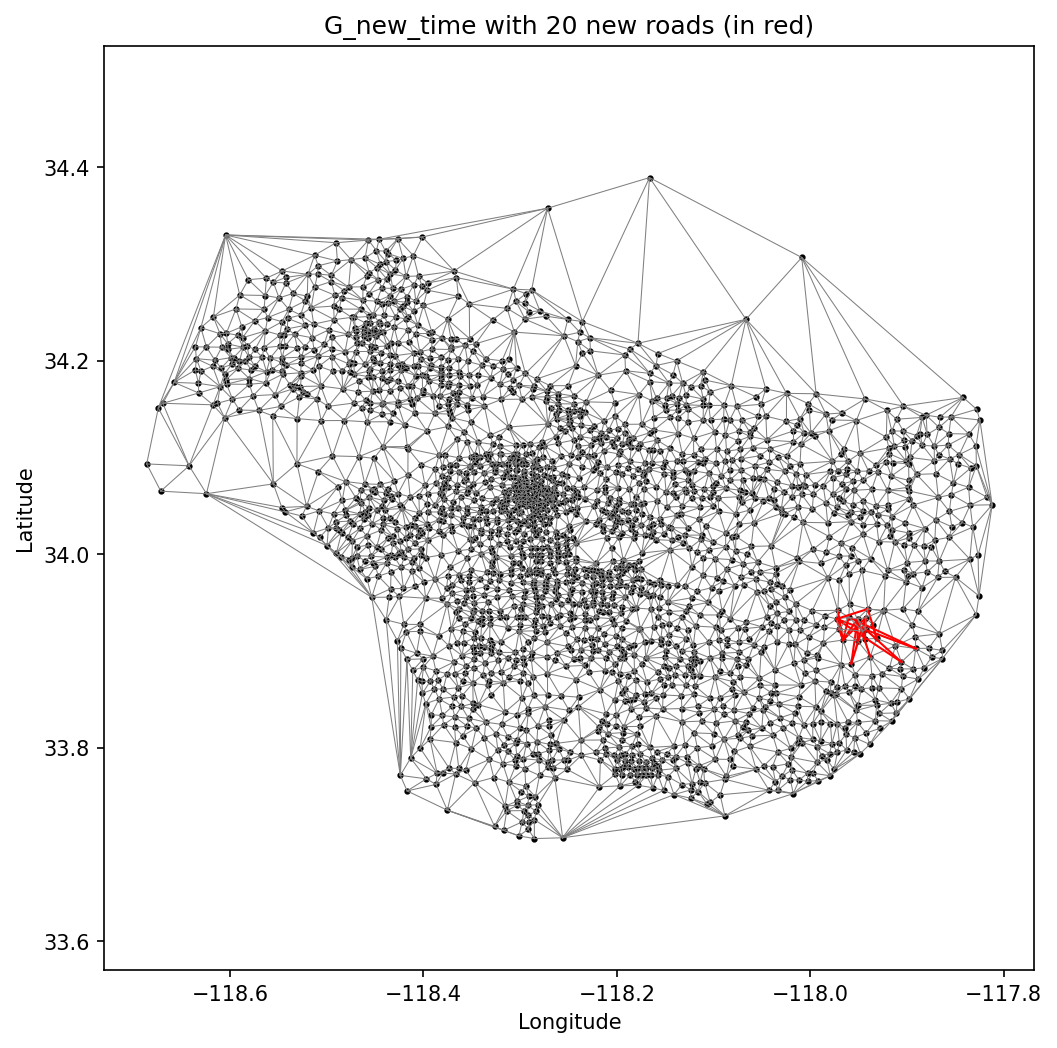


Time Complexity Analysis:
 • each single-source Dijkstra: O(m log n), repeated for n nodes → O(n * m log n)
 • for each reachable pair, computing extra time: ≤ O(n^2)
Overall: O(n * m log n + n^2). Worst-case m ~ n^2 → O(n^3).


In [22]:
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import zipfile
import os
import heapq

# 1. 解压数据
zip_path    = './data.zip'
extract_dir = './data-selected'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# 2. 加载质心
json_path = os.path.join(extract_dir, 'los_angeles_censustracts.json')
with open(json_path, 'r', encoding='utf-8') as f:
    geojson = json.load(f)
centroids = {}
for feat in geojson['features']:
    props = feat['properties']
    tract_id = int(props['TRACT'])
    geometry = feat['geometry']
    if geometry['type'] == 'Polygon':
        coords = np.array(geometry['coordinates'][0])
    else:
        coords = np.array(geometry['coordinates'][0][0])
    lon_mean = coords[:, 0].mean()
    lat_mean = coords[:, 1].mean()
    centroids[tract_id] = (lon_mean, lat_mean)

# 3. 从CSV加载 travel_time_dict
csv_path = os.path.join(extract_dir, 'los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv')
# 只读取所需列
import pandas as pd
df_raw = pd.read_csv(csv_path, usecols=['sourceid', 'dstid', 'mean_travel_time'])
travel_time_dict = {}
for _, row in df_raw.iterrows():
    u = int(row['sourceid'])
    v = int(row['dstid'])
    t = row['mean_travel_time']
    travel_time_dict[(u, v)] = t
    travel_time_dict[(v, u)] = t

# 4. 构造 G_delta (Delaunay) 及 G_pruned
nodes = list(centroids.keys())
points = np.array([centroids[n] for n in nodes])
tri = Delaunay(points)

G_delta = nx.Graph()
for tract_id, (lon, lat) in centroids.items():
    G_delta.add_node(tract_id, centroid=(lon, lat))
for simplex in tri.simplices:
    for i in range(3):
        u_idx = simplex[i]
        v_idx = simplex[(i+1) % 3]
        u, v = nodes[u_idx], nodes[v_idx]
        if not G_delta.has_edge(u, v):
            dist_deg = np.linalg.norm(points[u_idx] - points[v_idx])
            G_delta.add_edge(u, v, weight=dist_deg)

for u, v, data in G_delta.edges(data=True):
    if 'weight' not in data:
        lon1, lat1 = centroids[u]
        lon2, lat2 = centroids[v]
        data['weight'] = np.hypot(lat2 - lat1, lon2 - lon1)

threshold_deg = 19.2 / 69
G_pruned = nx.Graph()
for tract_id, (lon, lat) in centroids.items():
    G_pruned.add_node(tract_id, centroid=(lon, lat))
for u, v, data in G_delta.edges(data=True):
    if data['weight'] < threshold_deg:
        G_pruned.add_edge(u, v, weight=data['weight'])

# 5. 构造 G_time：与G_pruned同拓扑，用 travel_time 作为边权
G_time = nx.Graph()
for n, (lon, lat) in centroids.items():
    G_time.add_node(n)
for u, v in G_pruned.edges():
    if (u, v) in travel_time_dict:
        G_time.add_edge(u, v, weight=travel_time_dict[(u, v)])
# Now G_time edges have travel_time in minutes

# 6. 准备 degree 距离 lookup
deg_lookup = {}
for u, v, data in G_pruned.edges(data=True):
    deg_lookup[(u, v)] = data['weight']
    deg_lookup[(v, u)] = data['weight']

node_to_idx = {node: idx for idx, node in enumerate(nodes)}

# 7. 计算 extra time 并保留 Top20
heap_top20 = []

for v in nodes:
    # single-source Dijkstra on G_time
    try:
        dist_time, paths = nx.single_source_dijkstra(G_time, v, weight='weight')
    except Exception:
        continue
    for s, travel_time_min in dist_time.items():
        if s <= v:
            continue
        # 获取最短路径节点列表
        path = paths[s]
        # 计算路径总 degree 距离
        path_deg = 0.0
        for i in range(len(path)-1):
            u_, v_ = path[i], path[i+1]
            path_deg += deg_lookup.get((u_, v_), 0)
        path_miles = path_deg * 69
        # travel speed in miles per minute
        speed_mpm = path_miles / travel_time_min if travel_time_min>0 else 0
        # 直线度数距离
        v_idx = node_to_idx[v]
        s_idx = node_to_idx[s]
        lon_v, lat_v = points[v_idx]
        lon_s, lat_s = points[s_idx]
        euclid_deg = np.hypot(lon_v - lon_s, lat_v - lat_s)
        straight_miles = euclid_deg * 69
        straight_time_min = straight_miles / speed_mpm if speed_mpm>0 else np.inf
        extra_time = travel_time_min - straight_time_min
        if extra_time <= 0:
            continue
        if len(heap_top20) < 20:
            heapq.heappush(heap_top20, (extra_time, v, s))
        else:
            if extra_time > heap_top20[0][0]:
                heapq.heapreplace(heap_top20, (extra_time, v, s))

top20_pairs = sorted(heap_top20, key=lambda x: x[0], reverse=True)

print("Top 20 node pairs with highest extra time:")
for extra_time, v, s in top20_pairs:
    print(f"({v}, {s})  extra time (min) = {extra_time:.4f}")

# 8. 将 Top20 新边加入 G_pruned (用欧氏度数距离作为权重, 或 travel_time?)
G_new_time = G_pruned.copy()
for extra_time, v, s in top20_pairs:
    v_idx = node_to_idx[v]
    s_idx = node_to_idx[s]
    lon_v, lat_v = points[v_idx]
    lon_s, lat_s = points[s_idx]
    euclid_deg = np.hypot(lon_v - lon_s, lat_v - lat_s)
    if not G_new_time.has_edge(v, s):
        G_new_time.add_edge(v, s, weight=euclid_deg)

print("\nAfter adding 20 new time-optimized roads, G_new_time → nodes:", 
      G_new_time.number_of_nodes(), "edges:", G_new_time.number_of_edges())

# 9. 可视化 G_new_time，新增边红色，其它灰色
plt.figure(figsize=(8, 8), dpi=150)
for u, v, data in G_new_time.edges(data=True):
    lon1, lat1 = centroids[u]
    lon2, lat2 = centroids[v]
    if (u, v) in [(x[1], x[2]) for x in top20_pairs] or (v, u) in [(x[1], x[2]) for x in top20_pairs]:
        plt.plot([lon1, lon2], [lat1, lat2], c='red', linewidth=1.0)
    else:
        plt.plot([lon1, lon2], [lat1, lat2], c='gray', linewidth=0.5)
points_arr = np.array([centroids[n] for n in nodes])
plt.scatter(points_arr[:, 0], points_arr[:, 1], s=4, c='black')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('G_new_time with 20 new roads (in red)')
plt.axis('equal')
plt.show()

# 10. 时间复杂度分析
print("\nTime Complexity Analysis:")
print(" • each single-source Dijkstra: O(m log n), repeated for n nodes → O(n * m log n)")
print(" • for each reachable pair, computing extra time: ≤ O(n^2)")
print("Overall: O(n * m log n + n^2). Worst-case m ~ n^2 → O(n^3).")


Q23

G_pruned constructed → nodes: 2275 edges: 6793
New edge added: (1201, 1707)
New edge added: (1404, 1601)
New edge added: (1102, 1401)
New edge added: (1102, 1705)
New edge added: (1301, 1707)
New edge added: (1601, 1602)
New edge added: (1304, 1602)
New edge added: (1103, 1201)
New edge added: (1505, 1602)
New edge added: (1202, 1602)
New edge added: (1304, 1506)
New edge added: (1202, 1506)
New edge added: (1202, 1304)
New edge added: (1602, 1706)
New edge added: (1404, 1705)
New edge added: (1304, 1601)
New edge added: (1202, 1401)
New edge added: (1505, 1601)
New edge added: (1501, 1602)
New edge added: (1304, 1503)

Final list of 20 new edges:
1. (1201, 1707)
2. (1404, 1601)
3. (1102, 1401)
4. (1102, 1705)
5. (1301, 1707)
6. (1601, 1602)
7. (1304, 1602)
8. (1103, 1201)
9. (1505, 1602)
10. (1202, 1602)
11. (1304, 1506)
12. (1202, 1506)
13. (1202, 1304)
14. (1602, 1706)
15. (1404, 1705)
16. (1304, 1601)
17. (1202, 1401)
18. (1505, 1601)
19. (1501, 1602)
20. (1304, 1503)


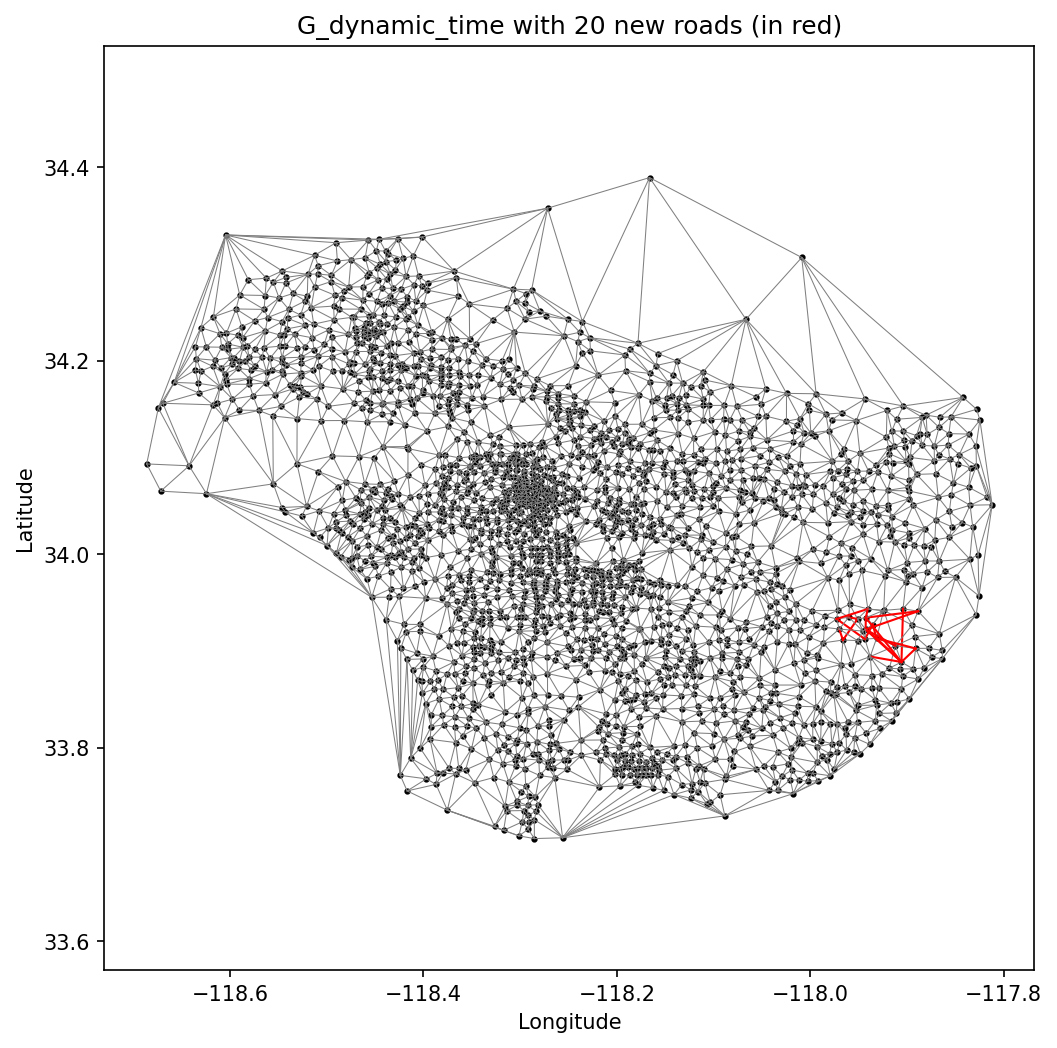


Time Complexity Analysis:
 • Each iteration (20 total):
   - Run single-source Dijkstra for each of n nodes on G_time → O(n * (m log n))
   - For each reachable pair, compute extra time → O(n^2)
   → Per iteration O(n·m·log n + n^2)
 • Total for 20 iterations: O(20 · (n·m·log n + n^2)) ≈ O(n·m·log n + n^2)
 • In worst case (m ~ n^2): O(n^3)


In [23]:
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import zipfile
import os
import heapq
import pandas as pd

# 第 1 步：解压 data.zip
zip_path    = './data.zip'
extract_dir = './data-selected'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# 第 2 步：从 GeoJSON 计算每个 Census Tract 的质心 centroids
json_path = os.path.join(extract_dir, 'los_angeles_censustracts.json')
with open(json_path, 'r', encoding='utf-8') as f:
    geojson = json.load(f)

centroids = {}
for feat in geojson['features']:
    props = feat['properties']
    tract_id = int(props['TRACT'])  # 将 'TRACT' 转为整数
    geometry = feat['geometry']
    if geometry['type'] == 'Polygon':
        coords = np.array(geometry['coordinates'][0])
    else:
        # 如果是 MultiPolygon，就取第一个 Polygon 的坐标
        coords = np.array(geometry['coordinates'][0][0])
    lon_mean = coords[:, 0].mean()
    lat_mean = coords[:, 1].mean()
    centroids[tract_id] = (lon_mean, lat_mean)

# 第 3 步：构造 Delaunay 图 G_delta 并进行地理剪枝生成 G_pruned
nodes  = list(centroids.keys())
points = np.array([centroids[n] for n in nodes])

# 3.a. Delaunay 三角剖分
tri = Delaunay(points)
G_delta = nx.Graph()
for tract_id in centroids:
    G_delta.add_node(tract_id)

for simplex in tri.simplices:
    for i in range(3):
        u_idx = simplex[i]
        v_idx = simplex[(i + 1) % 3]
        u, v = nodes[u_idx], nodes[v_idx]
        if not G_delta.has_edge(u, v):
            dist_deg = np.linalg.norm(points[u_idx] - points[v_idx])
            G_delta.add_edge(u, v, weight=dist_deg)

# 3.b. 补充缺失的 weight
for u, v, data in G_delta.edges(data=True):
    if 'weight' not in data:
        lon1, lat1 = centroids[u]
        lon2, lat2 = centroids[v]
        data['weight'] = np.hypot(lat2 - lat1, lon2 - lon1)

# 3.c. 地理剪枝：只保留度数距离 < 19.2/69
threshold_deg = 19.2 / 69
G_pruned = nx.Graph()
for tract_id in centroids:
    G_pruned.add_node(tract_id)

for u, v, data in G_delta.edges(data=True):
    if data['weight'] < threshold_deg:
        G_pruned.add_edge(u, v, weight=data['weight'])

print("G_pruned constructed → nodes:", G_pruned.number_of_nodes(),
      "edges:", G_pruned.number_of_edges())

# 第 4 步：流式读取 CSV，仅提取 G_pruned 中边的 travel_time
edge_set = set(G_pruned.edges())
travel_time_dict = {}
csv_path = os.path.join(extract_dir, 'los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv')
chunksize = 200_000
for chunk in pd.read_csv(csv_path,
                         usecols=['sourceid','dstid','mean_travel_time'],
                         chunksize=chunksize):
    for sourceid, dstid, mt in chunk.itertuples(index=False, name=None):
        u, v = int(sourceid), int(dstid)
        if (u, v) in edge_set:
            travel_time_dict[(u, v)] = mt
        if (v, u) in edge_set:
            travel_time_dict[(v, u)] = mt

# 第 5 步：构造 G_time，用 travel_time 作为边权
G_time = nx.Graph()
for n in centroids:
    G_time.add_node(n)
for u, v in G_pruned.edges():
    if (u, v) in travel_time_dict:
        G_time.add_edge(u, v, weight=travel_time_dict[(u, v)])

# 第 6 步：准备 deg_lookup，用于累加路径的度数距离
deg_lookup = {}
for u, v, data in G_pruned.edges(data=True):
    deg_lookup[(u, v)] = data['weight']
    deg_lookup[(v, u)] = data['weight']

node_to_idx = {node: idx for idx, node in enumerate(nodes)}

# 第 7 步：动态迭代 20 次，每次添加一条最大 extra time 的边
G_dynamic_time = G_pruned.copy()
G_dynamic_time_graph = G_time.copy()
added_edges = []

for k in range(20):
    max_extra = -np.inf
    best_pair = (None, None)
    best_straight_time = None

    # 遍历所有节点 v 作为源，跑单源 Dijkstra
    for v in nodes:
        if v not in G_dynamic_time_graph:
            continue
        dist_time, paths = nx.single_source_dijkstra(G_dynamic_time_graph, v, weight='weight')
        for s, travel_time_min in dist_time.items():
            if s <= v:
                continue

            # 计算目前最短路径的度数距离
            path = paths[s]
            path_deg = sum(deg_lookup[(path[i], path[i+1])] for i in range(len(path)-1))
            path_miles = path_deg * 69

            if travel_time_min <= 0:
                continue
            speed_mpm = path_miles / travel_time_min

            # 计算两点直线度数距离及英里数
            v_idx = node_to_idx[v]
            s_idx = node_to_idx[s]
            lon_v, lat_v = points[v_idx]
            lon_s, lat_s = points[s_idx]
            euclid_deg = np.hypot(lon_v - lon_s, lat_v - lat_s)
            straight_miles = euclid_deg * 69

            if speed_mpm <= 0:
                continue
            straight_time_min = straight_miles / speed_mpm

            extra_time = travel_time_min - straight_time_min
            if extra_time > max_extra:
                max_extra = extra_time
                best_pair = (v, s)
                best_straight_time = straight_time_min

    v, s = best_pair
    if v is None or s is None:
        break

    print(f"New edge added: ({v}, {s})")
    added_edges.append((v, s))

    # 计算新边的 travel_time（用直线 time）
    v_idx = node_to_idx[v]
    s_idx = node_to_idx[s]
    lon_v, lat_v = points[v_idx]
    lon_s, lat_s = points[s_idx]
    euclid_deg = np.hypot(lon_v - lon_s, lat_v - lat_s)
    new_travel_time = best_straight_time

    # 在 G_dynamic_time_graph （travel_time 图）中加入新边
    G_dynamic_time_graph.add_edge(v, s, weight=new_travel_time)
    # 在 G_dynamic_time （度数距离图）中加入新边
    G_dynamic_time.add_edge(v, s, weight=euclid_deg)

    # 更新 deg_lookup
    deg_lookup[(v, s)] = euclid_deg
    deg_lookup[(s, v)] = euclid_deg

# 打印 20 条新增边
print("\nFinal list of 20 new edges:")
for idx, (v, s) in enumerate(added_edges, 1):
    print(f"{idx}. ({v}, {s})")

# 第 8 步：可视化最终图 —— 新增边用红色，其余边用灰色
plt.figure(figsize=(8, 8), dpi=150)
new_edges_set = set(added_edges) | {(s, v) for (v, s) in added_edges}
for u, v, data in G_dynamic_time.edges(data=True):
    lon1, lat1 = centroids[u]
    lon2, lat2 = centroids[v]
    if (u, v) in new_edges_set:
        plt.plot([lon1, lon2], [lat1, lat2], c='red', linewidth=1.0)
    else:
        plt.plot([lon1, lon2], [lat1, lat2], c='gray', linewidth=0.5)

points_arr = np.array([centroids[n] for n in nodes])
plt.scatter(points_arr[:, 0], points_arr[:, 1], s=4, c='black')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('G_dynamic_time with 20 new roads (in red)')
plt.axis('equal')
plt.show()

# 第 9 步：时间复杂度分析
print("\nTime Complexity Analysis:")
print(" • Each iteration (20 total):")
print("   - Run single-source Dijkstra for each of n nodes on G_time → O(n * (m log n))")
print("   - For each reachable pair, compute extra time → O(n^2)")
print("   → Per iteration O(n·m·log n + n^2)")
print(" • Total for 20 iterations: O(20 · (n·m·log n + n^2)) ≈ O(n·m·log n + n^2)")
print(" • In worst case (m ~ n^2): O(n^3)")


Q24